# Introduction
  ## Problem Statement
  To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

  ## About the Dataset
The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion


## Preparation

### Setup

In [95]:
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8
!pip install Augmentor

Looking in indexes: https://test.pypi.org/simple/
Could not fetch URL https://test.pypi.org/simple/nbpep8/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='test.pypi.org', port=443): Max retries exceeded with url: /simple/nbpep8/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)'))) - skipping
ERROR: Could not find a version that satisfies the requirement nbpep8 (from versions: none)
ERROR: No matching distribution found for nbpep8


### Imports

In [134]:
import os
from pathlib import Path
import glob
import matplotlib.pyplot as plt
from skimage import io
import Augmentor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, \
        Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, \
        load_img, img_to_array, DirectoryIterator
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Rescaling, Resizing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
        ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

#from nbpep8.nbpep8 import pep8

# pep8(_ih)

In [97]:
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')

## Setup

### Subroutines

In [98]:
def plot_accuracy(history):
    """
    Plots the 'accuracy' and 'val_accuracy'
    :param history: history from the model fitting
    :return:
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()


def plot_distribution(directory: str):
    """
    Calculates the class distribution in the data directory
    :param directory: dataset directory with class as subdir
    :return: dict of class:sample-count
    """
    print(f"Looking for files under {os.path.abspath(directory)}")
    class_size = dict()
    # Iterate through each subdirectory in the given directory
    for subdir, _, files in os.walk(directory):
        if files:
            condition = str(subdir).split('/')[-1]
            class_size.update({condition.upper(): len(files)})
    return class_size


def distribution(directory: str):
    """
    Calculates the class distribution in the data directory
    :param directory: dataset directory with class as subdir
    :return: dict of class:sample-count
    """
    class_size = dict()
    # Iterate through each subdirectory in the given directory
    for subdir, _, files in os.walk(directory):
        if files:
            condition = str(subdir).split('/')[-1]
            class_size.update({condition.upper(): len(files)})
    return class_size


# pep8(_ih)

### Constants

In [99]:
DATA_PATH = '/content/drive/MyDrive/MLAI_Notebooks/data/ISIC_skin_cancer/'
DATA_PATH = '/Users/pchinnas/Learn/AIML/Data/golden/Skin cancer ISIC The International Skin Imaging Collaboration'
BATCH_SIZE = 32
RANDOM_SEED = 123
MAX_EPOCHS_20 = 20
MAX_EPOCHS_30 = 30
IMG_SIZE = (180, 180)
IMG_CH_SHAPE = (180, 180, 3)
INPUT_SHAPE = (BATCH_SIZE, 180, 180, 3)
AUG_SAMPLE_PER_CLASS_AUGM = 1000
AUG_INC_PER_CLASS_KERAS = 350
AUTOTUNE = tf.data.experimental.AUTOTUNE

# pep8(_ih)

### Dataset Creation

In [100]:
os.chdir(DATA_PATH)
train_dir = Path("./Train")
test_dir = Path('./Test')

In [101]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

len(train_ds)
class_names = train_ds.class_names

Found 8989 files belonging to 9 classes.


In [102]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 118 files belonging to 9 classes.


### Visualize the Data

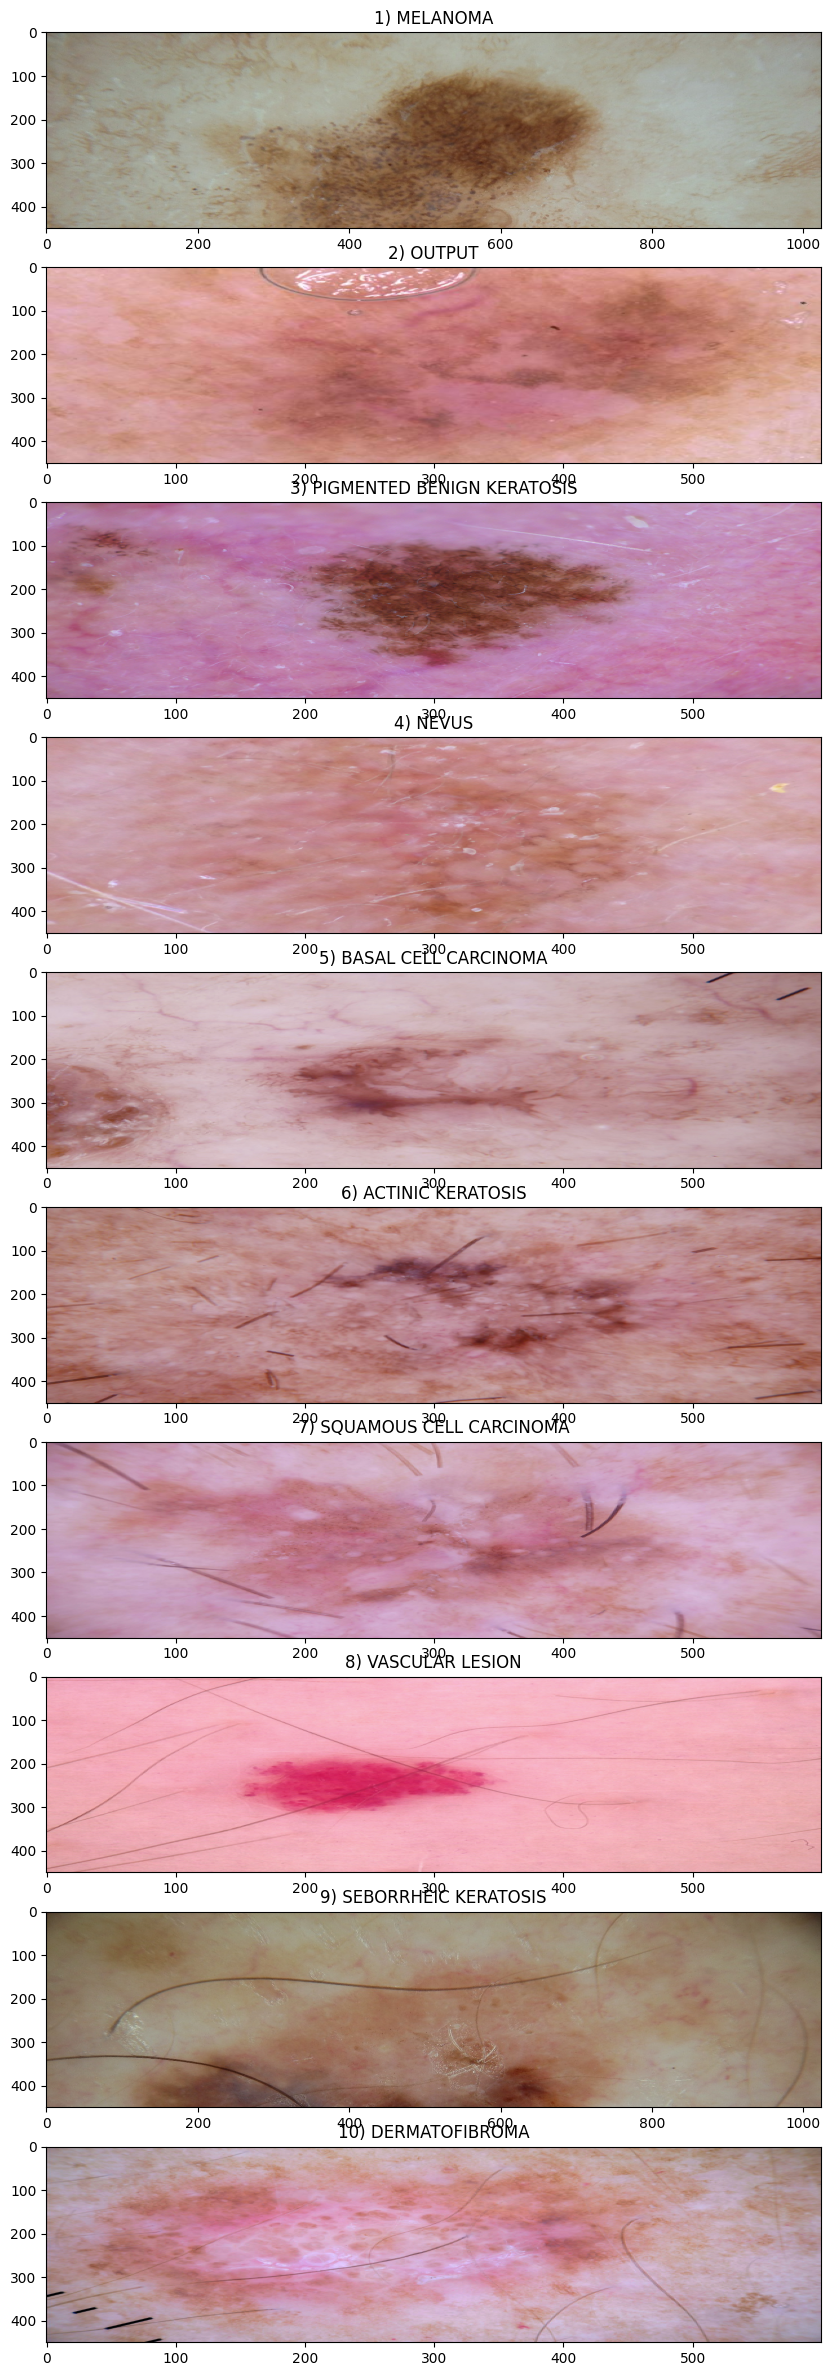

In [103]:
import random

def pick_cond_img(directory: str):
    """
    Picks a random file for each condition
    :param directory:
    :return:
    """
    selected_files = dict()

    # Iterate through each subdirectory in the given directory
    for subdir, _, files in os.walk(directory):
        if files:
            # Pick a random file from the current subdirectory
            selected_file = random.choice(files)
            img_path = os.path.join(subdir, selected_file)
            condition = str(subdir).split('/')[-1]
            selected_files.update({condition.upper(): img_path})
    return selected_files
cond_img = pick_cond_img(train_dir)

f, axes = plt.subplots(len(cond_img), 1, sharey=True, figsize=(10, 30))

i = 0
for cond, img_path in cond_img.items():
    img = io.imread(img_path)
    axes[i].imshow(img, aspect='auto')
    axes[i].title.set_text(str(i+1) + ') ' + cond)
    i += 1
plt.show()

# pep8(_ih)

## Model - 1

In [104]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache() \
    .shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# pep8(_ih)

### Class Distribution

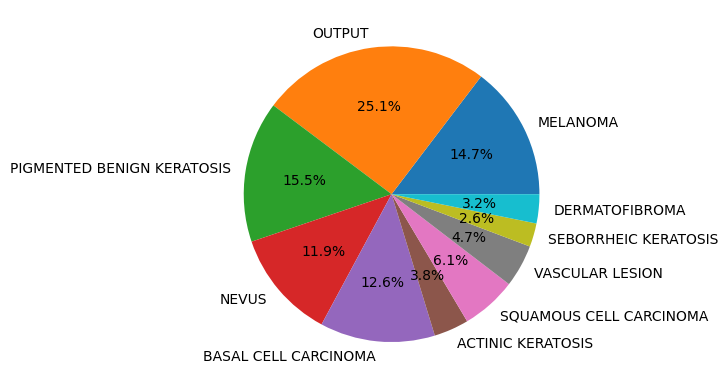

Looking for files under /Users/pchinnas/Learn/AIML/Data/golden/Skin cancer ISIC The International Skin Imaging Collaboration/Train


{'MELANOMA': 438,
 'OUTPUT': 750,
 'PIGMENTED BENIGN KERATOSIS': 462,
 'NEVUS': 357,
 'BASAL CELL CARCINOMA': 376,
 'ACTINIC KERATOSIS': 114,
 'SQUAMOUS CELL CARCINOMA': 181,
 'VASCULAR LESION': 139,
 'SEBORRHEIC KERATOSIS': 77,
 'DERMATOFIBROMA': 95}

In [105]:
class_dist = distribution(train_dir)
plt.pie(class_dist.values(), labels=class_dist.keys(), autopct='%1.1f%%')
plt.show()
class_dist
plot_distribution(os.path.join(DATA_PATH, train_dir))

# pep8(_ih)

#### Findings

- 'seborrheic keratosis' has 3.4% (77) of the samples and hence is the least
- 'pigmented benign keratosis' has 20.6%(462) at the highest, closely followed by 'melanoma' at 19.6%(438)


### Build

In [106]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, \
    Conv2D, MaxPooling2D, BatchNormalization

model = Sequential([
    Input(shape=IMG_CH_SHAPE, batch_size=BATCH_SIZE),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# pep8(_ih)

In [107]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 176, 176, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 88, 88, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (32, 86, 86, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 43, 43, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (32, 118336)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 32)               │     3,786,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 64)               │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (32, 9)                │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,845,801 (14.67 MB)

 Trainable params: 3,845,801 (14.67 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [108]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=MAX_EPOCHS_20,
  callbacks=[early_stopping]
)

print(f"\nBest accuracy: {max(history.history['accuracy'])}")

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


281/281 ━━━━━━━━━━━━━━━━━━━━ 179s 615ms/step - accuracy: 0.1477 - loss: 14.4169 - val_accuracy: 0.1695 - val_loss: 2.5928
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 181s 642ms/step - accuracy: 0.1929 - loss: 2.1315 - val_accuracy: 0.1186 - val_loss: 2.5782
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 183s 651ms/step - accuracy: 0.2575 - loss: 1.9516 - val_accuracy: 0.1271 - val_loss: 2.6028
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 181s 644ms/step - accuracy: 0.3209 - loss: 1.8345 - val_accuracy: 0.1441 - val_loss: 2.8623
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 187s 667ms/step - accuracy: 0.2050 - loss: 2.0602 - val_accuracy: 0.1186 - val_loss: 3.4842
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 182s 649ms/step - accuracy: 0.4098 - loss: 1.6569 - val_accuracy: 0.1271 - val_loss: 5.6767
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 186s 661ms/step - accuracy: 0.4270 - loss: 1.5798 - val_accuracy: 0.1525 - val_loss: 6.3300

Best accuracy: 0.4707976281642914


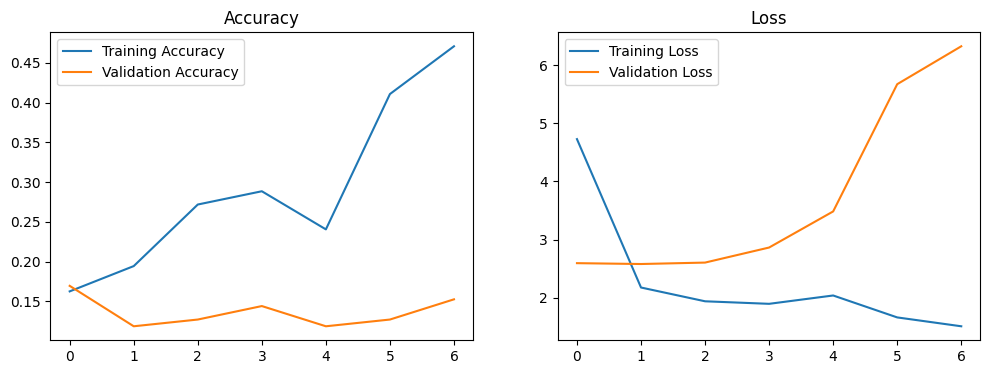

In [109]:
plot_accuracy(history)

### Findings
- Accuracy is low at** 47.5% **. This can be attributed to the following
    - Not having enough labeled training data can lead to poor generalization. CNNs require large amounts of diverse data to learn effectively.
    - Imbalanced Dataset: If some classes have significantly more samples than others, the model might become biased toward the more frequent classes, leading to poor performance on the less frequent ones.
- **Overfitting**: When a model performs well on training data but poorly on validation data, it might be overfitting. This can occur if the model is too complex relative to the amount of training data.

## Model - 2

### Build

In [110]:
# resize and rescale the value
resize_and_rescale = Sequential([
    tf.keras.layers.Resizing(180, 180),
    tf.keras.layers.Rescaling(1.0/255)
])

In [111]:
keras_augmentation = Sequential([
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical")
])

In [112]:
from tensorflow.keras.layers import Rescaling, Resizing

model = Sequential([
    Input(shape=IMG_CH_SHAPE, batch_size=BATCH_SIZE),
    resize_and_rescale,
    keras_augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

In [113]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (32, 176, 176, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 88, 88, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (32, 86, 86, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 43, 43, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (32, 118336)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (32, 32)               │     3,786,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (32, 64)               │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (32, 9)                │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,845,801 (14.67 MB)

 Trainable params: 3,845,801 (14.67 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [114]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=MAX_EPOCHS_20,
  callbacks=[early_stopping]
)

print(f"\nBest accuracy: {max(history.history['accuracy'])}")

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 191s 676ms/step - accuracy: 0.1951 - loss: 2.1157 - val_accuracy: 0.3136 - val_loss: 1.8731
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 180s 642ms/step - accuracy: 0.4016 - loss: 1.5517 - val_accuracy: 0.3305 - val_loss: 2.3209
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 175s 624ms/step - accuracy: 0.4312 - loss: 1.4743 - val_accuracy: 0.3305 - val_loss: 2.0360
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 192s 683ms/step - accuracy: 0.4440 - loss: 1.4180 - val_accuracy: 0.3644 - val_loss: 2.3361
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 192s 684ms/step - accuracy: 0.4685 - loss: 1.3562 - val_accuracy: 0.4068 - val_loss: 2.0874
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 188s 668ms/step - accuracy: 0.4739 - loss: 1.3322 - val_accuracy: 0.3559 - val_loss: 2.1382

Best accuracy: 0.47547000646591187


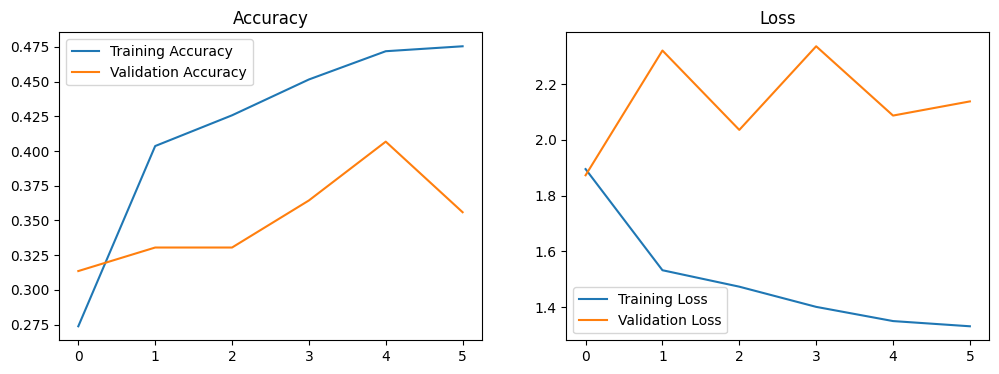

In [115]:
plot_accuracy(history)

### Findings
- Validation accuracy has not improved (**47.5%**)
- There is a clear case of overfitting
- Total trainable params are 3,845,801
- The class imbalance can be a cause of this overfitting
- A good sample size can help the model quality



## Model - 3

### Augmenting Data

In [128]:
import Augmentor
for class_name in class_names:
    p = Augmentor.Pipeline(os.path.join(train_dir, class_name))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(AUG_SAMPLE_PER_CLASS_AUGM)

# pep8(_ih)

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x36934A180>: 100%|█| 1000/1000 [00:02<00


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x364BB4290>: 100%|█| 1000/1000 [00:02<00


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x32EF1DCA0>: 100%|█| 1000/1000 [00:02<00


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x32EF18350>: 100%|█| 1000/1000 [00:13<0


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x365B14860>: 100%|█| 1000/1000 [00:10<


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x365A20EF0>: 100%|█| 1000/1000 [00:02<00


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x376F1FCE0>: 100%|█| 1000/1000 [00:05<0


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x364B05010>: 100%|█| 1000/1000 [00:02<00


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x331D9A330>: 100%|█| 1000/1000 [00:03<00


In [135]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=RANDOM_SEED,
    validation_split=0.2,
    subset='training',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# pep8(_ih)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [136]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=RANDOM_SEED,
    validation_split=0.2,
    subset='validation',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# pep8(_ih)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [137]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Build

In [138]:
model = Sequential([
    Input(shape=IMG_CH_SHAPE, batch_size=BATCH_SIZE),

    Rescaling(1.0/255),

    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    # BatchNormalization(),
    # MaxPooling2D((2, 2)),

    Dropout(0.25),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),

    Dropout(0.5),

    Dense(len(class_names), activation='softmax')
])

# pep8(_ih)

In [139]:
adam = Adam(learning_rate=0.0001)

model.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(INPUT_SHAPE)
model.summary()

# pep8(_ih)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (32, 178, 178, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (32, 178, 178, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (32, 89, 89, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (32, 87, 87, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (32, 87, 87, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (32, 43, 43, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (32, 41, 41, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (32, 41, 41, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (32, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (32, 18, 18, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (32, 18, 18, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (32, 9, 9, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (32, 9, 9, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (32, 5184)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (32, 128)              │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (32, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,057 (2.77 MB)

 Trainable params: 725,705 (2.77 MB)

 Non-trainable params: 352 (1.38 KB)

### Train

In [140]:
optimizer = Adam(learning_rate=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("model.keras",monitor="val_loss",save_best_only=True,mode="auto",verbose=1)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1, epsilon=1e-4, min_lr=0.00001)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=MAX_EPOCHS_30,
    callbacks=[early_stopping, checkpoint, reduce_lr_loss]
)
print(f"\nBest accuracy: {max(history.history['accuracy'])}")

# pep8(_ih)

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2228 - loss: 6.1990
Epoch 1: val_loss improved from inf to 6.82118, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 60s 194ms/step - accuracy: 0.2231 - loss: 6.1969 - val_accuracy: 0.1326 - val_loss: 6.8212 - learning_rate: 1.0000e-04
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4506 - loss: 4.8954
Epoch 2: val_loss improved from 6.82118 to 4.71839, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 51s 183ms/step - accuracy: 0.4507 - loss: 4.8951 - val_accuracy: 0.4775 - val_loss: 4.7184 - learning_rate: 1.0000e-04
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5290 - loss: 4.4855
Epoch 3: val_loss improved from 4.71839 to 3.99648, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 51s 183ms/step - accuracy: 0.5291 - loss: 4.4853 - val_accuracy: 0.6858 - val_loss: 3.9965 - learning_rate: 1.0000e-04
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0

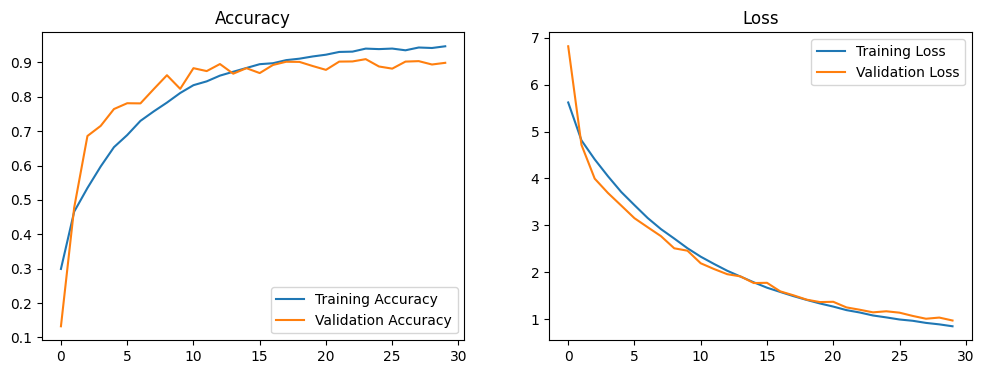

In [141]:
plot_accuracy(history)

### Findings


- After increasing the size of the training dataset, the accuracy has improved (**94.6%**).
- Total trainable params are 725,705
- Overfitting is contained with the help of
    - BatchNormalization
    - Dropouts
    - EarlyStopping
- The model also runs with a Learning rate scheduler both with
ReduceLROnPlateau and with Adam optimizer with less lr value




## Analysis

In [142]:
model.evaluate(validation_ds)

71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8926 - loss: 0.9721


[0.9695644378662109, 0.8985313773155212]

In [143]:
print("Best Score:", max(history.history['accuracy']))

Best Score: 0.9466192126274109


In [144]:
acc = ['accuracy', 'val_accuracy']
loss = ['loss', 'val_loss']
for s in acc:
    print(s, max(history.history[s]))
for s in loss:
    print(s, min(history.history[s]))

# pep8(_ih)

accuracy 0.9466192126274109
val_accuracy 0.9092122912406921
loss 0.8464059233665466
val_loss 0.9695644378662109


### Prediction:

Test/basal cell carcinoma/*
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Actual Class 'basal cell carcinoma 
Predictive Class 'basal cell carcinoma'


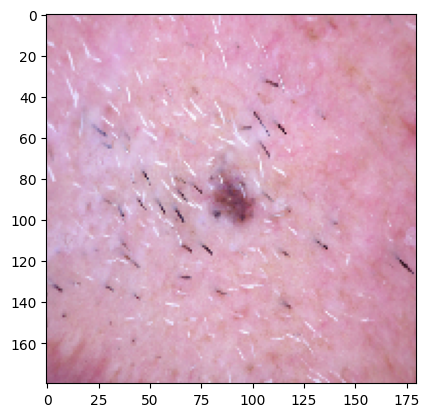

In [145]:
from glob import glob
import numpy as np
class_name = class_names[1]
Test_image_path = os.path.join(test_dir, class_name, '*')
print(Test_image_path)
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1], target_size=(180, 180, 3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image, axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class '{class_name} \nPredictive Class '{pred_class}'")

# pep8(_ih)

### Model on Unseen Test data

In [146]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=RANDOM_SEED,
    validation_split=0.2,
    subset='validation',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [147]:
optimizer = Adam(learning_rate=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("model.keras",monitor="val_loss",save_best_only=True,mode="auto",verbose=1)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1, epsilon=1e-4, min_lr=0.00001)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=MAX_EPOCHS_30,
    callbacks=[early_stopping, checkpoint, reduce_lr_loss]
)
print(f"\nBest accuracy: {max(history.history['accuracy'])}")

# pep8(_ih)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9450 - loss: 0.8325
Epoch 1: val_loss improved from inf to 3.87447, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 49s 174ms/step - accuracy: 0.9450 - loss: 0.8325 - val_accuracy: 0.3913 - val_loss: 3.8745 - learning_rate: 1.0000e-04
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9476 - loss: 0.8045
Epoch 2: val_loss did not improve from 3.87447
281/281 ━━━━━━━━━━━━━━━━━━━━ 59s 209ms/step - accuracy: 0.9476 - loss: 0.8045 - val_accuracy: 0.3478 - val_loss: 4.6747 - learning_rate: 1.0000e-04
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9447 - loss: 0.7874
Epoch 3: val_loss did not improve from 3.87447
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step - accuracy: 0.9447 - loss: 0.7874 - val_accuracy: 0.2609 - val_loss: 4.2927 - learning_rate: 1.0000e-04
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9574 - loss: 0.7398
Epoch 4: val_loss did not improve 

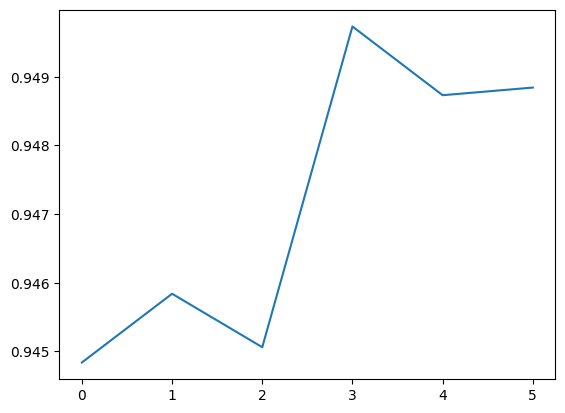

In [149]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.show()

## Conclusion:
- The model is finally up to satisfaction.
- Training and Test paths are defined (train_dir, test_dir)
- Datasets were created (train_ds, validation_ds, test_ds)
- Data for all 9 classes are visualized
- Model-1 built with vanilla daset - accuracy was low and overfitting was noticed
- Model-2 built and run with keras augmentation - accuracy was better but sill low with overfitting
- Model-3 built and run with Augmentor created dataset with steps to curtail overfitting
- Data augmentation done with Keras and Augmentor libraries
- Class distribution was done and imbalance was noticed. It is fixed with Augmentor
- Coded with nbpep8 lib and documentation where it is required.
